In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210614'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

16it [00:01, 10.18it/s]


(637843, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(635273, 21)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '영등포구'
target_dong = '대림동'
#target_purpose = '준주거'
target_building_age = 3
target_period = 36 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(186, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
573098,서울특별시 영등포구 대림동 907-1,신길로13길 3,드림하우스,36.89,24.77,28000,2,2016.0,3.0,2019-02-22,759.013283,5.0,연립다세대,대,155.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로한면,영등포구,대림동
573099,서울특별시 영등포구 대림동 907-1,신길로13길 3,드림하우스,48.78,32.75,44000,5,2016.0,5.0,2021-02-09,902.009020,5.0,연립다세대,대,155.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로한면,영등포구,대림동
573126,서울특별시 영등포구 대림동 684-20,대림로34마길 4,베스트하우스,49.62,33.97,30000,2,2016.0,2.0,2018-07-02,604.594921,5.0,연립다세대,대,232.1,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,영등포구,대림동
573127,서울특별시 영등포구 대림동 684-20,대림로34마길 4,베스트하우스,46.53,31.85,35000,5,2016.0,3.0,2019-10-13,752.202880,5.0,연립다세대,대,232.1,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,영등포구,대림동
573128,서울특별시 영등포구 대림동 684-20,대림로34마길 4,베스트하우스,46.02,31.50,38300,5,2016.0,4.0,2020-08-10,832.246849,5.0,연립다세대,대,232.1,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,영등포구,대림동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(186, 25)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
573098,서울특별시 영등포구 대림동 907-1,신길로13길 3,드림하우스,36.89,24.77,28000,2,2016.0,3.0,2019-02-22,759.013283,5.0,연립다세대,대,155.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로한면,영등포구,대림동,905.182933,2021-03-01
573099,서울특별시 영등포구 대림동 907-1,신길로13길 3,드림하우스,48.78,32.75,44000,5,2016.0,5.0,2021-02-09,902.009020,5.0,연립다세대,대,155.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로한면,영등포구,대림동,911.949554,2021-03-01
573126,서울특별시 영등포구 대림동 684-20,대림로34마길 4,베스트하우스,49.62,33.97,30000,2,2016.0,2.0,2018-07-02,604.594921,5.0,연립다세대,대,232.1,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,영등포구,대림동,727.546382,2021-03-01
573127,서울특별시 영등포구 대림동 684-20,대림로34마길 4,베스트하우스,46.53,31.85,35000,5,2016.0,3.0,2019-10-13,752.202880,5.0,연립다세대,대,232.1,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,영등포구,대림동,861.121928,2021-03-01
573128,서울특별시 영등포구 대림동 684-20,대림로34마길 4,베스트하우스,46.02,31.50,38300,5,2016.0,4.0,2020-08-10,832.246849,5.0,연립다세대,대,232.1,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,영등포구,대림동,894.390456,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [19]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,층,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 영등포구 대림동 1016-21,아데나팰리스,5.0,4,35.72,2018-11-21,29000,811.870101,2021-03-01,970.838863,제2종일반주거지역,연립다세대
1,서울특별시 영등포구 대림동 1016-21,아데나팰리스,5.0,6,38.44,2020-08-31,30000,780.437045,2021-03-01,838.712030,제2종일반주거지역,연립다세대
2,서울특별시 영등포구 대림동 1018-10,크리에이션빌,5.0,3,34.98,2020-02-23,20500,586.049171,2021-03-01,657.169533,제2종일반주거지역,연립다세대
3,서울특별시 영등포구 대림동 1018-10,크리에이션빌,5.0,2,34.98,2021-04-19,25000,714.694111,2021-04-19,714.694111,제2종일반주거지역,연립다세대
4,서울특별시 영등포구 대림동 1019-22,베스트하우스II,5.0,2,29.95,2019-08-01,23000,767.946578,2021-03-01,891.572202,제2종일반주거지역,연립다세대


In [20]:
target_df1_30 = target_df1[
    (target_df1['전용면적(㎡)'] >= 28)
    &(target_df1['전용면적(㎡)'] <= 32)
]

In [21]:
target_df1_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가_30.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

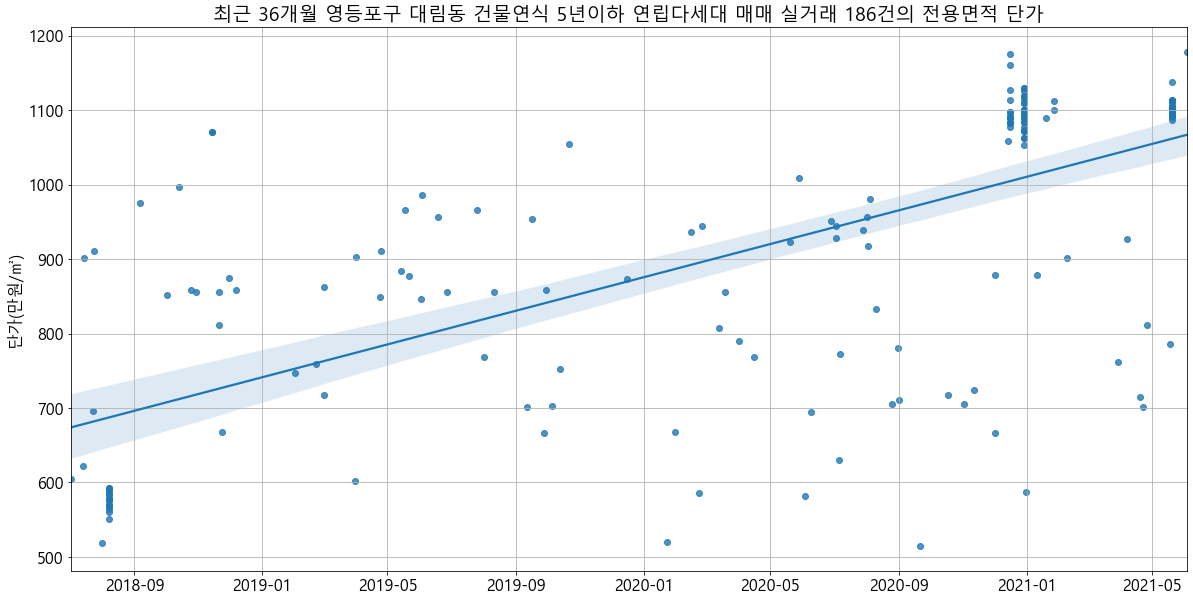

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

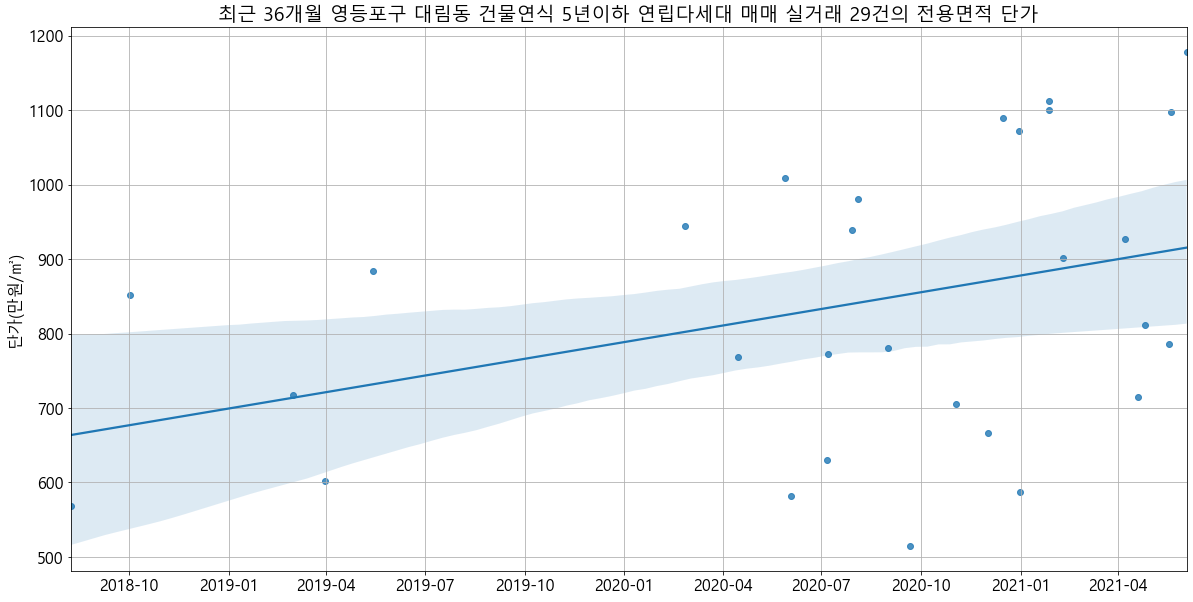

In [24]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [25]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [26]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(855, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
219979,서울특별시 영등포구 대림동 655-4,대림로44길 23,(655-4),75.55,30.19,12000,5,2003.0,3.0,2006-05-02,158.835208,18.0,연립다세대,대,164.3,제2종일반주거지역,지정되지않음,주상용,평지,세로장방,소로각지,영등포구,대림동
220001,서울특별시 영등포구 대림동 874-14,대림로12나길 9-1,(874-14),60.03,43.46,11500,2,2003.0,3.0,2006-04-10,191.570881,18.0,연립다세대,대,136.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),영등포구,대림동
220002,서울특별시 영등포구 대림동 874-14,대림로12나길 9-1,(874-14),37.77,27.34,7000,1,2003.0,3.0,2006-04-10,185.332274,18.0,연립다세대,대,136.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),영등포구,대림동
220003,서울특별시 영등포구 대림동 874-14,대림로12나길 9-1,(874-14),90.07,65.20,14500,3,2003.0,3.0,2006-04-10,160.985900,18.0,연립다세대,대,136.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로한면(가),영등포구,대림동
220008,서울특별시 영등포구 대림동 875-13,대림로12가길 9,(875-13),85.29,57.79,18900,3,2002.0,4.0,2006-12-12,221.596905,19.0,연립다세대,대,175.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),영등포구,대림동


In [27]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'영등포구 대림동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 855건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

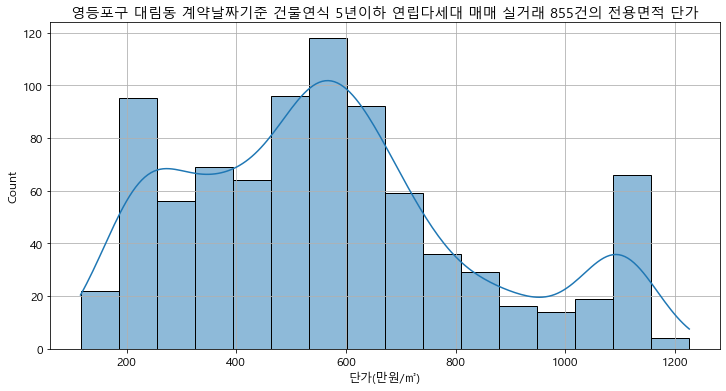

In [28]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [29]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [30]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [31]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가_30.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [32]:
concat_df = pd.concat([target_df2])

In [33]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [34]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [35]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(437, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 영등포구 대림동 1015-19,디지털로56길 20-1,리츠빌,29.50,19.94,11450,5,2013.0,0.0,2013-08-26,388.135593,8.0,연립다세대,대,198.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),영등포구,대림동,571.006296,2021-03-01,394.780838,580.782458
1,서울특별시 영등포구 대림동 1015-19,디지털로56길 20-1,리츠빌,29.97,20.25,11600,5,2013.0,0.0,2013-08-26,387.053720,8.0,연립다세대,대,198.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),영등포구,대림동,569.414697,2021-03-01,394.780838,580.782458
2,서울특별시 영등포구 대림동 1015-19,디지털로56길 20-1,리츠빌,31.05,20.98,12450,4,2013.0,0.0,2013-08-26,400.966184,8.0,연립다세대,대,198.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),영등포구,대림동,589.882039,2021-03-01,394.780838,580.782458
3,서울특별시 영등포구 대림동 1015-19,디지털로56길 20-1,리츠빌,32.62,22.05,13150,3,2013.0,0.0,2013-08-26,403.126916,8.0,연립다세대,대,198.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),영등포구,대림동,593.060804,2021-03-01,394.780838,580.782458
4,서울특별시 영등포구 대림동 1015-19,디지털로56길 20-1,리츠빌,45.74,30.91,18050,3,2013.0,0.0,2013-08-26,394.621775,8.0,연립다세대,대,198.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),영등포구,대림동,580.548453,2021-03-01,394.780838,580.782458


In [36]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(146, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
4,서울특별시 영등포구 대림동 1015-19,디지털로56길 20-1,리츠빌,45.740,30.91,18050,3,2013.0,0.0,2013-08-26,394.621775,8.0,연립다세대,대,198.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),영등포구,대림동,580.548453,2021-03-01,394.780838,580.782458
9,서울특별시 영등포구 대림동 1016-21,대림로 99,아데나팰리스,38.440,22.96,30000,6,2016.0,4.0,2020-08-31,780.437045,5.0,연립다세대,대,587.0,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,중로한면,영등포구,대림동,838.712030,2021-03-01,877.939729,1095.111423
11,서울특별시 영등포구 대림동 1018-10,대림로10길 2-2,크리에이션빌,34.980,21.38,25000,2,2016.0,5.0,2021-04-19,714.694111,5.0,연립다세대,대,268.0,제2종일반주거지역,지정되지않음,단독,평지,자루형,세로한면(가),영등포구,대림동,714.694111,2021-04-19,626.777107,710.297808
14,서울특별시 영등포구 대림동 1019-22,대림로 101-4,베스트하우스II,59.280,41.26,34800,4,2016.0,4.0,2020-12-31,587.044534,5.0,연립다세대,대,142.0,제2종일반주거지역,지정되지않음,단독,평지,사다리형,세로한면(불),영등포구,대림동,599.283184,2021-03-01,667.319684,778.527338
15,서울특별시 영등포구 대림동 1023-13,디지털로48가길 12,하나빌라트,66.400,31.52,17200,3,2002.0,4.0,2006-12-16,259.036145,19.0,연립다세대,대,155.0,제2종일반주거지역,지정되지않음,주상기타,평지,부정형,세로각지(가),영등포구,대림동,494.573346,2021-03-01,259.036145,494.573346
16,서울특별시 영등포구 대림동 1025-16,디지털로48가길 8,대림 노벨리티빌,73.530,33.74,16600,3,2002.0,4.0,2006-09-16,225.758194,19.0,연립다세대,대,261.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,세로각지(가),영등포구,대림동,477.498974,2021-03-01,225.758194,477.498974
22,서울특별시 영등포구 대림동 1025-9,디지털로48가길 2,더행복한집,46.830,29.31,26100,3,2013.0,2.0,2015-01-12,557.335042,8.0,연립다세대,대,225.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로각지(가),영등포구,대림동,811.430321,2021-03-01,559.494052,821.906933
25,서울특별시 영등포구 대림동 1026-36,디지털로52길 8-4,레이나,42.040,27.73,26400,3,2014.0,5.0,2019-10-12,627.973359,7.0,연립다세대,대,96.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로각지(가),영등포구,대림동,718.903961,2021-03-01,636.451809,754.698261
29,서울특별시 영등포구 대림동 1027-2,디지털로52길 11-2,삼미아트빌,56.940,36.27,29300,3,2016.0,4.0,2020-09-21,514.576747,5.0,연립다세대,대,162.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),영등포구,대림동,543.821547,2021-03-01,607.552640,765.068910
31,서울특별시 영등포구 대림동 1033-14,디지털로53길 6-4,성원하이츠,35.030,21.00,17000,5,2011.0,1.0,2012-09-24,485.298316,10.0,연립다세대,대,168.0,제2종일반주거지역,지정되지않음,다세대,평지,정방형,세로각지(가),영등포구,대림동,701.772410,2021-03-01,488.740646,712.669635


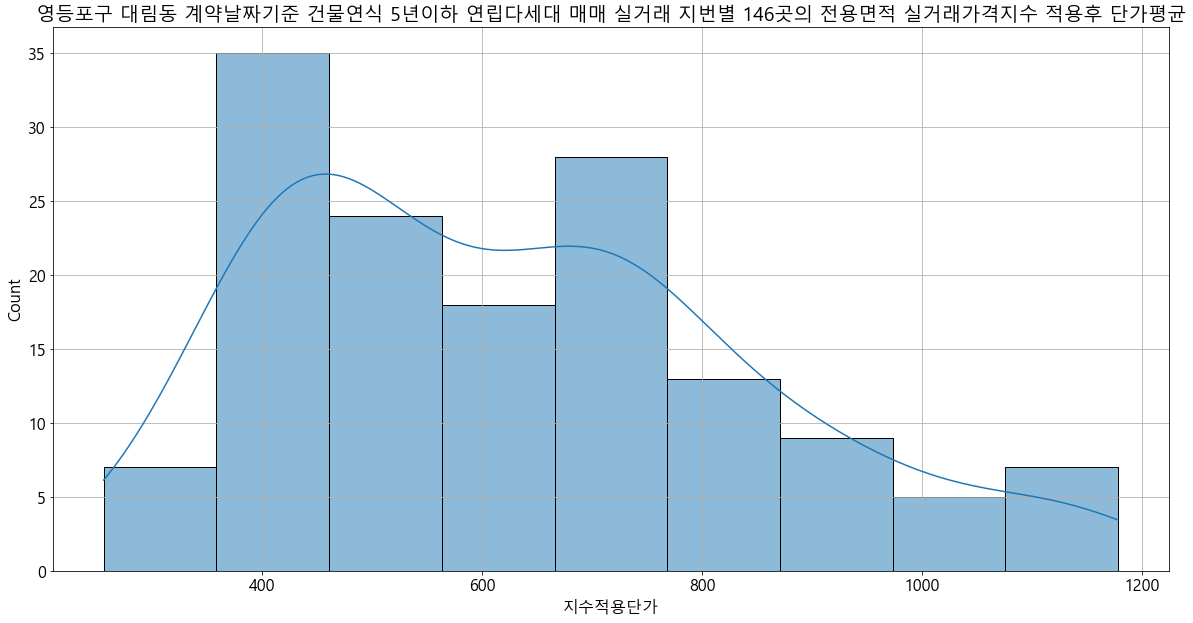

In [37]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [38]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [39]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 영등포구 대림동 1015-19,리츠빌,2013.0,45.74,3,2013-08-26,394.621775,2021-03-01,580.548453,제2종일반주거지역,연립다세대
1,서울특별시 영등포구 대림동 1016-21,아데나팰리스,2016.0,38.44,6,2020-08-31,780.437045,2021-03-01,838.712030,제2종일반주거지역,연립다세대
2,서울특별시 영등포구 대림동 1018-10,크리에이션빌,2016.0,34.98,2,2021-04-19,714.694111,2021-04-19,714.694111,제2종일반주거지역,연립다세대
3,서울특별시 영등포구 대림동 1019-22,베스트하우스II,2016.0,59.28,4,2020-12-31,587.044534,2021-03-01,599.283184,제2종일반주거지역,연립다세대
4,서울특별시 영등포구 대림동 1023-13,하나빌라트,2002.0,66.40,3,2006-12-16,259.036145,2021-03-01,494.573346,제2종일반주거지역,연립다세대


In [40]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)